In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import time
import numpy as np
from load_data_and_distribution_analisys import split_dataset_v1, plot_confusion_matrix, load_data

# Feature engeneering

In questo notebook viene invece effettuato quello che prende il nome di feature engeneering: consiste nella creazione, trasformazione, selezione ed in generale ottimizzazione delle feature di un dataset per migliorare le performance di un modello di Machine Learning. Abbiamo fatto delle ricerche inerenti il dominio di cui ci siamo occupati in questo progetto e abbiamo creato delle nuove feature in modo da creare un dataset con dei parametri differenti da quelli che avevamo a disposizione all'inizio; ovviamente l'obiettivo di tutto ciò è stato cercare di migliorare le performance dei nostri modelli predittivi.

In [4]:
dataset = load_data()

Path to dataset files: /Users/marcodeano/.cache/kagglehub/datasets/sooyoungher/smoking-drinking-dataset/versions/2


## Features antropometriche

In [5]:
dataset['BMI'] = dataset['weight'] / (dataset['height'] / 100) ** 2
dataset['wth_ratio'] = dataset['waistline'] / dataset['height']
dataset['wtw_ratio'] = dataset['waistline'] / dataset['weight']
dataset['obesity_flag'] = (dataset['BMI'] >= 30).astype(int)

## Features cardiovascolari

In [6]:
def bp_category(row):
    if row['SBP'] < 120 and row['DBP'] < 80:
        return 'Normal'
    elif row['SBP'] < 140 and row['DBP'] < 90:
        return 'Prehypertensive'
    else:
        return 'Hypertensive'

dataset['pulse_pressure'] = dataset['SBP'] - dataset['DBP']
dataset['MAP'] = (2 * dataset['DBP'] + dataset['SBP']) / 3
dataset['bp_category'] = dataset.apply(bp_category, axis=1)

## Profilo lipidico e rapporti metabolici

In [7]:
dataset['TC_HDL_ratio'] = dataset['tot_chole'] / dataset['HDL_chole']
dataset['LDL_HDL_ratio'] = dataset['LDL_chole'] / dataset['HDL_chole']                              
dataset['non_HDL_chole'] = dataset['tot_chole'] - dataset['HDL_chole']
dataset['triglyceride_hdl_ratio'] = dataset['triglyceride'] / dataset['HDL_chole']      

dataset["AIP"] = np.log10(dataset['triglyceride'] / dataset['HDL_chole'])

dataset['TyG'] = np.log(dataset['triglyceride'] * dataset['BLDS'] / 2)                   

## Features inerenti la funzione epatica e renale

In [ ]:
def calc_eGFR(row):
    SCr = row['serum_creatinine']
    age = row['age']
    is_female = row['sex'] == 'Female'
    
    k = 0.7 if is_female else 0.9
    a = -0.329 if is_female else -0.411

    eGFR = 141 * min(SCr / k, 1) ** a * max(SCr / k, 1) ** (-1.209) * 0.993 ** age
    eGFR *= 1.018 if is_female else 1

    return eGFR

dataset['AST_ALT_ratio'] = dataset['SGOT_AST'] / dataset['SGOT_ALT']
dataset['liver_enzyme_avg'] = (dataset['SGOT_AST'] + dataset['SGOT_ALT'] + dataset['gamma_GTP']) / 3
dataset['eGFR'] = dataset.apply(calc_eGFR, axis=1)

In [9]:
label_encoders = {}

for column in dataset.columns:
    if dataset[column].dtype == 'object':
        label_encoders[column] = LabelEncoder()
        dataset[column] = label_encoders[column].fit_transform(dataset[column])

In [10]:
dataset.head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,DBP,BLDS,tot_chole,HDL_chole,LDL_chole,triglyceride,hemoglobin,urine_protein,serum_creatinine,SGOT_AST,SGOT_ALT,gamma_GTP,SMK_stat_type_cd,DRK_YN,BMI,wth_ratio,wtw_ratio,obesity_flag,pulse_pressure,MAP,bp_category,TC_HDL_ratio,LDL_HDL_ratio,non_HDL_chole,triglyceride_hdl_ratio,AIP,TyG,AST_ALT_ratio,liver_enzyme_avg,eGFR
0,1,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,80.0,99.0,193.0,48.0,126.0,92.0,17.1,1.0,1.0,21.0,35.0,40.0,1.0,1,25.951557,0.529412,1.200000,0,40.0,93.333333,2,4.020833,2.625000,145.0,1.916667,0.282547,8.423761,0.600000,32.000000,97.078265
1,1,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,82.0,106.0,228.0,55.0,148.0,121.0,15.8,1.0,0.9,20.0,36.0,27.0,3.0,0,24.691358,0.494444,1.112500,0,48.0,98.000000,2,4.145455,2.690909,173.0,2.200000,0.342423,8.766082,0.555556,27.666667,114.208011
2,1,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,70.0,98.0,136.0,41.0,74.0,104.0,15.8,1.0,0.9,47.0,32.0,68.0,1.0,0,27.548209,0.551515,1.213333,0,50.0,86.666667,2,3.317073,1.804878,95.0,2.536585,0.404249,8.536211,1.468750,49.000000,106.460635
3,1,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,87.0,95.0,201.0,76.0,104.0,106.0,17.6,1.0,1.1,29.0,34.0,18.0,1.0,0,26.122449,0.520000,1.137500,0,58.0,106.333333,0,2.644737,1.368421,125.0,1.394737,0.144492,8.524169,0.852941,27.000000,77.860462
4,1,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,82.0,101.0,199.0,61.0,117.0,104.0,13.8,1.0,0.8,19.0,12.0,25.0,1.0,0,22.038567,0.484848,1.333333,0,56.0,100.666667,2,3.262295,1.918033,138.0,1.704918,0.231704,8.566364,1.583333,18.666667,104.161020


# Predizioni

In [11]:
X_smoke, y_smoke, X_drink, y_drink = split_dataset_v1(dataset)

In [12]:
pipelines = {
    "rf": Pipeline([("scaler", StandardScaler()), ("rf", RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=50 , random_state=42, n_jobs=-1, class_weight="balanced"))]),
    "adaboost": Pipeline([("scaler", StandardScaler()), ("adaboost", AdaBoostClassifier(n_estimators=200, random_state=42))]),
    "svm": Pipeline([("scaler", StandardScaler()), ("svm", LinearSVC(random_state=42, C=0.1, class_weight="balanced"))]),
    "knn": Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=500, n_jobs=-1))]),
}

In [13]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_drink, y_drink, test_size=0.2, random_state=42, stratify=y_drink)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_smoke, y_smoke, test_size=0.2, random_state=42, stratify=y_smoke)

### Drinking

In [14]:
for name, pipeline in pipelines.items():
    print(f"Training {name}...", end=" ")
    t0 = time.time()

    pipeline.fit(X_train_d, y_train_d)  
    
    print(f"took {time.time() - t0:.2f} seconds")

Training rf... took 42.71 seconds
Training adaboost... 

/Users/marcodeano/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


took 191.26 seconds
Training svm... took 12.64 seconds
Training knn... took 0.22 seconds


Classification report per rf:
              precision    recall  f1-score   support

           0       0.74      0.72      0.73     99172
           1       0.73      0.75      0.74     99098

    accuracy                           0.73    198270
   macro avg       0.73      0.73      0.73    198270
weighted avg       0.73      0.73      0.73    198270



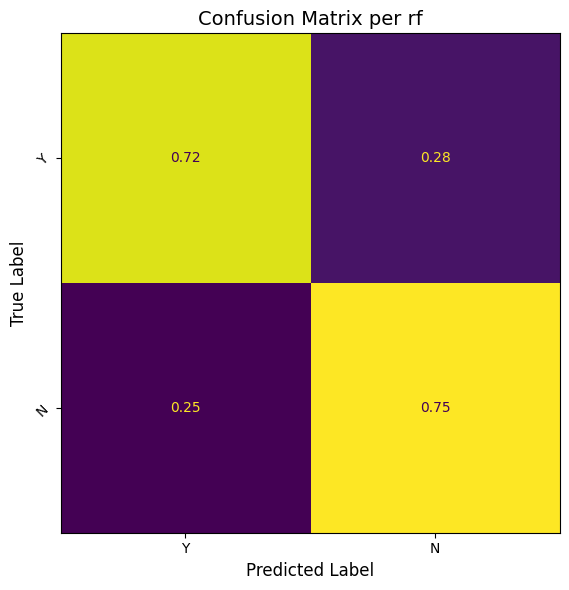

Classification report per adaboost:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73     99172
           1       0.73      0.74      0.73     99098

    accuracy                           0.73    198270
   macro avg       0.73      0.73      0.73    198270
weighted avg       0.73      0.73      0.73    198270



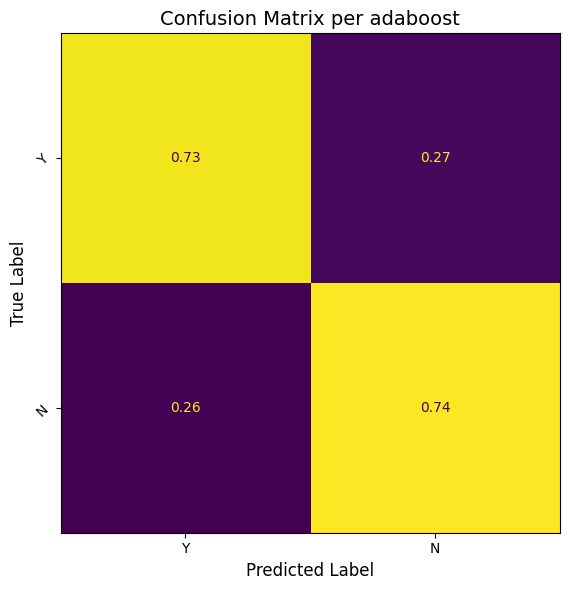

Classification report per svm:
              precision    recall  f1-score   support

           0       0.73      0.72      0.72     99172
           1       0.72      0.73      0.72     99098

    accuracy                           0.72    198270
   macro avg       0.72      0.72      0.72    198270
weighted avg       0.72      0.72      0.72    198270



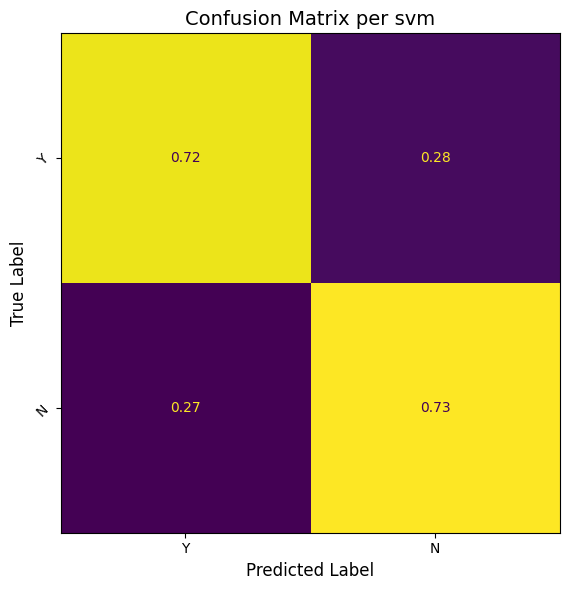

Classification report per knn:
              precision    recall  f1-score   support

           0       0.73      0.67      0.70     99172
           1       0.70      0.76      0.73     99098

    accuracy                           0.71    198270
   macro avg       0.72      0.71      0.71    198270
weighted avg       0.72      0.71      0.71    198270



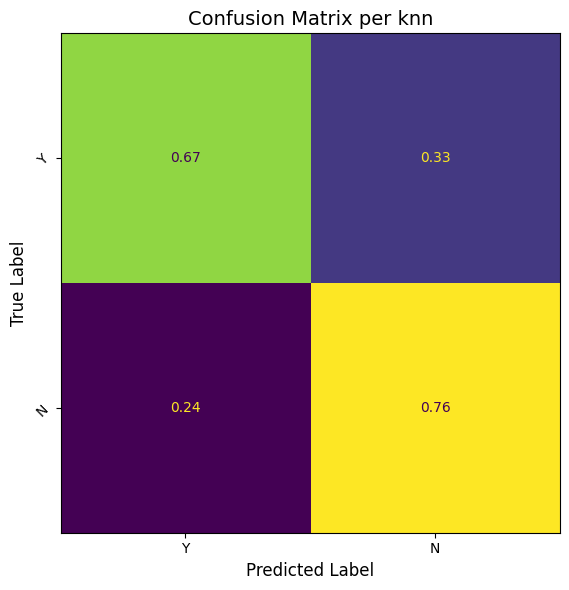

In [15]:
for name, pipeline in pipelines.items():
    y_pred_drink = pipeline.predict(X_test_d)

    report_drink = classification_report(y_test_d, y_pred_drink)

    print(f"Classification report per {name}:")
    print(report_drink)

    plot_confusion_matrix(y_test_d, y_pred_drink, ["Y", "N"], f"Confusion Matrix per {name}")

### Smoking

In [16]:
for name, pipeline in pipelines.items():
    print(f"Training {name}...", end=" ")
    t0 = time.time()

    pipeline.fit(X_train_s, y_train_s)  
    
    print(f"took {time.time() - t0:.2f} seconds")

Training rf... took 41.42 seconds
Training adaboost... 

/Users/marcodeano/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


took 195.65 seconds
Training svm... took 52.23 seconds
Training knn... took 0.28 seconds


Classification report per rf:
              precision    recall  f1-score   support

         1.0       0.94      0.73      0.82    120489
         2.0       0.42      0.58      0.48     34990
         3.0       0.49      0.64      0.56     42791

    accuracy                           0.68    198270
   macro avg       0.62      0.65      0.62    198270
weighted avg       0.75      0.68      0.70    198270



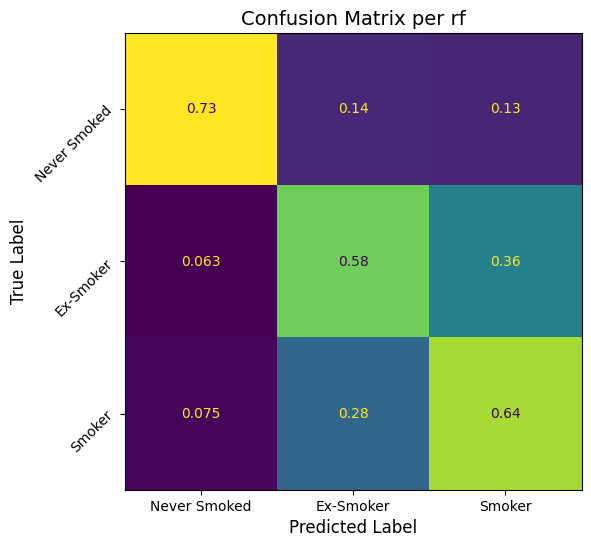

Classification report per adaboost:
              precision    recall  f1-score   support

         1.0       0.83      0.83      0.83    120489
         2.0       0.44      0.32      0.37     34990
         3.0       0.51      0.62      0.56     42791

    accuracy                           0.70    198270
   macro avg       0.59      0.59      0.59    198270
weighted avg       0.69      0.70      0.69    198270



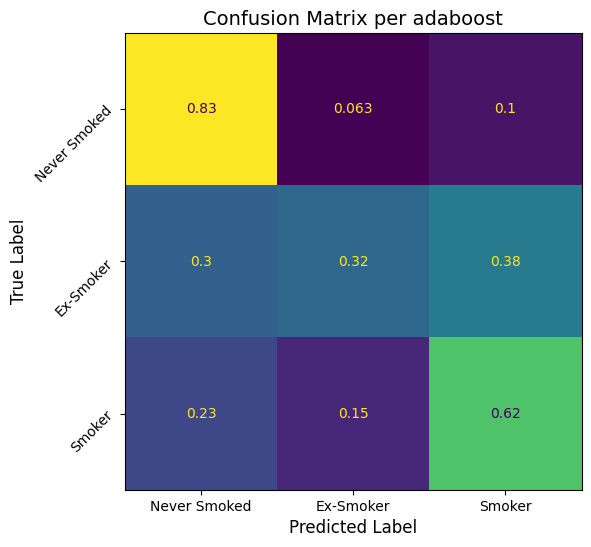

Classification report per svm:
              precision    recall  f1-score   support

         1.0       0.94      0.73      0.82    120489
         2.0       0.41      0.55      0.47     34990
         3.0       0.48      0.65      0.55     42791

    accuracy                           0.68    198270
   macro avg       0.61      0.64      0.61    198270
weighted avg       0.75      0.68      0.70    198270



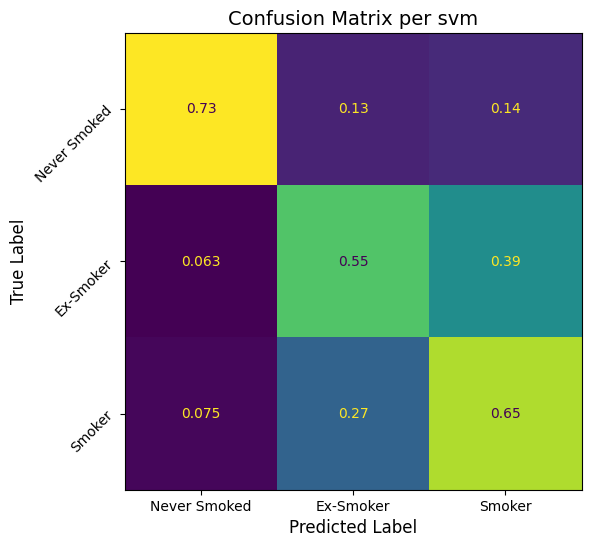

Classification report per knn:
              precision    recall  f1-score   support

         1.0       0.84      0.81      0.83    120489
         2.0       0.43      0.38      0.41     34990
         3.0       0.49      0.58      0.53     42791

    accuracy                           0.69    198270
   macro avg       0.59      0.59      0.59    198270
weighted avg       0.69      0.69      0.69    198270



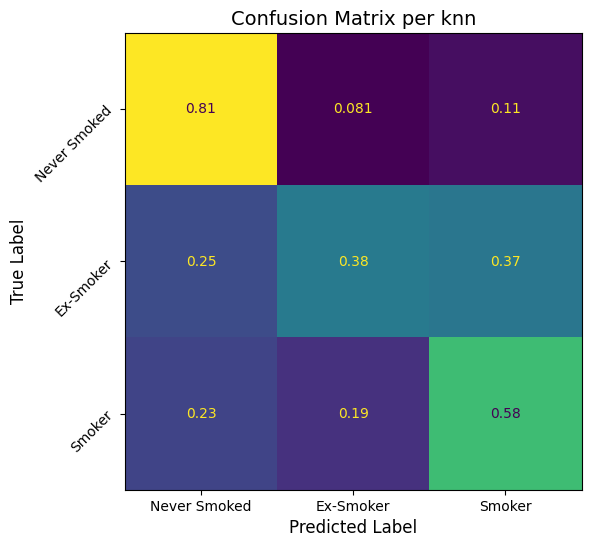

In [17]:
for name, pipeline in pipelines.items():
    y_pred_smoke = pipeline.predict(X_test_s)

    report_smoke = classification_report(y_test_s, y_pred_smoke)

    print(f"Classification report per {name}:")
    print(report_smoke)

    plot_confusion_matrix(y_test_s, y_pred_smoke, ["Never Smoked", "Ex-Smoker", "Smoker"], f"Confusion Matrix per {name}")